In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
    
from scipy.stats import itemfreq, chisquare, kstest, norm
import scipy.integrate as integrate
import numpy as np
import sys
sys.path.append('../../prngs-and-permutations/Code/modules')
from sha256prng import SHA256

def distrNormalRange(w, n):
    '''
    The CDF of the range of n IID standard normals evaluated at w
    '''
    innerInt = lambda x: norm.pdf(x)*(norm.cdf(x+w) - norm.cdf(x))**(n-1)
    tmp = integrate.quad(innerInt, -2*w, 2*w)
    if n*tmp[0] > 1:
        return n*(tmp[0] - tmp[1])
    else:
        return n*tmp[0]

def distrMultinomialRange(w, n, k):
    '''
    CDF of the range of multinomial variables, evaluated at w
    n draws, k categories each having probability 1/k
    '''
    cutoff = (w - 1/(2*n))*np.sqrt(k/n)
    return distrNormalRange(cutoff, k)

def conductRangeTest(counts):
    return 1 - distrMultinomialRange(np.ptp(counts), np.sum(counts), len(counts))


# Equidistribution tests

## Tests based on binning the PRNs

Let's generate 10^7 PRNs. We'll scale them by 1000 and take the floor -- effectively, we're looking at only the first 3 digits of the PRNs.  Then, we can tally up how many of each occurs and do the chi-squared test and range test on these counts.

In [5]:
ss = 100 # seed value
prng = SHA256(ss)

bin_counts = [int(np.floor(prng.random()*1000)) for i in range(10**7)]

In [9]:
chisquare(itemfreq(bin_counts)[:,1])

Power_divergenceResult(statistic=985.93920000000003, pvalue=0.609703394705852)

In [15]:
conductRangeTest(itemfreq(bin_counts)[:,1])

0.3871586650604306

Let's do the same thing for the randint method:

In [16]:
ss = 100 # seed value
prng = SHA256(ss)

bin_counts = [prng.randint(1, 21) for i in range(10**7)]

In [17]:
chisquare(itemfreq(bin_counts)[:,1])

Power_divergenceResult(statistic=11.687260000000002, pvalue=0.89855453012962583)

In [18]:
conductRangeTest(itemfreq(bin_counts)[:,1])

0.8910682080071386

And we'll do it again, taking modulus instead of floor:

In [20]:
ss = 100 # seed value
prng = SHA256(ss)

bin_counts = [int(prng.nextRandom() % 13) for i in range(10**7)]

In [21]:
chisquare(itemfreq(bin_counts)[:,1])

Power_divergenceResult(statistic=11.5701304, pvalue=0.48079037069126962)

In [22]:
conductRangeTest(itemfreq(bin_counts)[:,1])

0.6811907587409376

## Kolmogorov-Smirnov test

In [38]:
ss = 100 # seed value
prng = SHA256(ss)

prns = prng.random(10**7)

In [39]:
kstest(prns, 'uniform')

KstestResult(statistic=0.00044107848612390255, pvalue=0.04084928509400116)

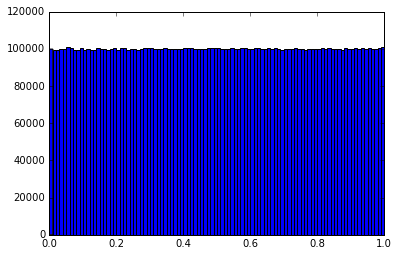

In [40]:
plt.hist(prns, bins = 100)
plt.show()

# Serial tests

We'll use a chi-squared test to count how often pairs of integers occur.

In [50]:
ss = 100 # seed value
prng = SHA256(ss)

bin_counts = [str(np.floor(prng.random()*100)) + "," + str(np.floor(prng.random()*100)) for i in range(int(10**7/2))]

In [51]:
print(bin_counts[:5])
bin_counts = itemfreq(bin_counts)
chisquare(bin_counts[:,1].astype('int'))

['20.0,90.0', '93.0,43.0', '84.0,74.0', '76.0,62.0', '67.0,3.0']


Power_divergenceResult(statistic=10152.828, pvalue=0.13852676704983599)

# Gap test

For values $\alpha < \beta$, we say that a gap of length $r$ occurs when $U_j$ and $U_{j+r-1}$ lie in the interval $(\alpha,\beta)$ but $U_{j+1}, \dots, U_{j + r - 2}$ do not. We want to count the number of gaps of size $0$, $1,$ up to size $t$ for some reasonable value.

This is slightly different from Knuth's version.  He proposes generating random numbers until $n$ gaps are observed.  Instead, I will fix the sequence length and count how many gaps occur.  Then I'll condition on that number of gaps (same as the number of items in the range $(\alpha, \beta)$) to generate expected counts for each gap length.

In [63]:
def gap_test(sequence, alpha, beta, t):
    '''
    inputs:
    sequence = sequence of numbers between 0 and 1
    alpha    = lower limit of interval
    beta     = upper limit of interval
    t        = max gap size (anything with gap larger than t will fall in the last category)
    '''
    # check
    assert alpha >= 0
    assert beta <= 1
    assert alpha < beta
    
    # initialize
    count = [0 for r in range(t+1)]
    r = 0
    n = len(sequence)
    
    # count gaps of size 0, 1, ..., >=t
    for j in range(n):
        if sequence[j] >= alpha and sequence[j] < beta:
            if r >= t:
                count[t] += 1
            else:
                count[r] += 1
            r = 0
        else:
            r += 1
            
    # conduct chi-square test
    p = beta-alpha
    conditional_n = sum(count)
    expected = [conditional_n*p*(1-p)**power for power in range(t)]
    expected.append(conditional_n*(1-p)**t)
    return {'observed' :  count,
            'expected' : expected,
            'chisquare' : chisquare(count, expected)}

In [64]:
ss = 100 # seed value
prng = SHA256(ss)

prns = prng.random(10**3)
gap_test(prns, 0.25, 0.75, 5)

{'chisquare': Power_divergenceResult(statistic=8.9111111111111114, pvalue=0.1126625960831215),
 'expected': [247.5, 123.75, 61.875, 30.9375, 15.46875, 15.46875],
 'observed': [252, 109, 71, 39, 8, 16]}

# Partition (Poker) test